In [1]:
import numpy as np
import pandas as pd
from scipy.io import netcdf
from scipy import signal
from datetime import datetime
import matplotlib.pyplot as plt
import random as rand
from wavesim1d import *



#Load a sample avg spectra
#Each spectra is every 30min
#fname = "/Volumes/TFO-exFAT-1/TFO/LCDRI/CDIPwaverider229/229p1_d01.nc";
fname = "/Users/jamesstadler/Documents/UW/TFO/Data/LCDRI/229p1_d01.nc"
[times, f, spectra] = load_CDIP(fname)

stop_point=int(len(times)/2)
#stop_point = 10
Gains = np.zeros([59, stop_point])


#Initialize the arrays for storing the diff spectra
Exx_surf_arr = np.zeros([59, stop_point])
Exx_Eric4_arr = np.zeros([59, stop_point])
Exx_Eric2_arr = np.zeros([59, stop_point])
input_arr = np.zeros([spectra.shape[1], stop_point])


for i in range(stop_point):
    test_spectra = np.nanmean(spectra[i*2:(i+1)*2, :], 0)

    nblock = 120
    overlap = int(nblock/2)
    fs = 1
    Cmax = 25
    w = nblock

    
    t_range_surf = np.arange(0, 1000, 1)
    n_iter = 500

    fs = 1

    #Em-APEX Sampling Grid
    t_range = np.arange(0, 1000)
    t_range, em_x, em_z = apex_sampling_grid(t_range)

    #build the u-time-series
    [u_store, u_noise, u_store_surf] = build_u_timeseries(t_range, em_z, em_x, test_spectra, f)

    #Apply highpass filter
    sos = signal.butter(10, 0.04, 'hp', fs=1, output='sos')
    u_noise = signal.sosfilt(sos, u_noise, axis=-1)
    
    #Reshape the u time series
    [u_new, z_new] = reshape_u(u_store, em_z, nblock, overlap, fs)
    [u_new_noise, z_new] = reshape_u(u_noise, em_z, nblock, overlap, fs)

    
    
    #Make the actual spectra by calling the function above
    UUwindow, fwindow= make_vel_spectrum(u_new, fs)
    UUwindow_noise, fwindow = make_vel_spectrum(u_new_noise, fs)


    #Compute the raw Energy Density Spectra
    UU = np.nanmean(np.nanmean(UUwindow, axis=0), axis=0)/(int(w/2)*fs)
    #UU_noise = np.nanmean(np.nanmean(UUwindow_noise, axis=0), axis=0)/(int(w/2)*fs)
    Exx = UU[1:]/ (np.square((2*np.pi*fwindow[1:])))
    #Exx_noise = UU_noise[1:]/ (np.square((2*np.pi*fwindow[1:])))


    #Apply Eric's Correction
    [UUwindow_Eric1, UUwindow_Eric2, UUwindow_Eric3, UUwindow_Eric4] = depth_correct_Eric(UUwindow_noise, fwindow, z_new, w, Cmax, fs)
    #Compute the raw Energy Density Spectra
    UU_Eric1 = np.nanmean(np.nanmean(UUwindow_Eric1, axis=0), axis=0)/(int(w/2)*fs)
    Exx_Eric1 = UU_Eric1[1:]/ (np.square((2*np.pi*fwindow[1:])))

    UU_Eric2 = np.nanmean(np.nanmean(UUwindow_Eric2, axis=0), axis=0)/(int(w/2)*fs)
    Exx_Eric2 = UU_Eric2[1:]/ (np.square((2*np.pi*fwindow[1:])))

    UU_Eric3 = np.nanmean(np.nanmean(UUwindow_Eric3, axis=0), axis=0)/(int(w/2)*fs)
    Exx_Eric3 = UU_Eric3[1:]/ (np.square((2*np.pi*fwindow[1:])))

    UU_Eric4 = np.nanmean(np.nanmean(UUwindow_Eric4, axis=0), axis=0)/(int(w/2)*fs)
    Exx_Eric4 = UU_Eric4[1:]/ (np.square((2*np.pi*fwindow[1:])))
    
    [u_surf, z_new] = reshape_u(u_store_surf, t_range_surf, nblock, overlap, fs)

    UUwindow_surf, fwindow_surf= make_vel_spectrum(u_surf, fs)
    UU_surf = np.nanmean(UUwindow_surf, axis=0)/(int(w/2)*fs)
    Exx_surf = np.nanmean(UU_surf[:, 1:], axis=0)/ (np.square((2*np.pi*fwindow_surf[1:])))

    
    
    Exx_surf_arr[:, i] = Exx_surf
    Exx_Eric4_arr[:, i] = Exx_Eric4
    Exx_Eric2_arr[:, i] = Exx_Eric2
    input_arr[:, i] = test_spectra
    
#     fixed = Exx_Eric2/p(fwindow[1:])
    

#     lbound = np.where(fwindow[1:]>=f[0])[0][0]
#     ubound = np.where(f<=fwindow[-1])[0][-1]
    
#     swh_base = sig_wave_height(f[:ubound], test_spectra[:ubound])
#     swh_eric = sig_wave_height(fwindow[lbound:], Exx_Eric4[lbound-1:])
#     swh_fixed = sig_wave_height(fwindow[lbound:], fixed[lbound-1:])
    
#     input_Hs = np.append(input_Hs, swh_base)
#     measured_Hs = np.append(measured_Hs, swh_eric)
#     fixed_Hs = np.append(fixed_Hs, swh_fixed)          
        
#     Gains[:, i] = Exx_Eric2/Exx_surf
    
    
    #if i==109:
    #plt.figure()
    #plt.loglog(fwindow[1:], Exx_surf, 'b')
    #plt.loglog(fwindow[1:], Exx_Eric4, 'k')
    #plt.loglog(fwindow[1:], Exx_Eric2, 'g')
    #plt.loglog(f, test_spectra, 'r')
        
    #plt.figure()
    #plt.scatter(fwindow[1:], Gain)

    #fit = np.polyfit(fwindow[1:], Gain, 2)
    #p = np.poly1d(fit)
    #xp = np.linspace(0, 0.5, 100)
    #plt.plot(xp, p(xp))

    #minus = Gain/p(fwindow[1:])
    #fixed = Exx_Eric2/p(fwindow[1:])
    #plt.plot(fwindow[1:], minus, 'o')

    
        
        
        
#plt.figure()       
#plt.plot(input_Hs, label = "Input Spectra SWH")
#plt.plot(measured_Hs, label="D'Asaro Corrected Spectra SWH")
#plt.plot(fixed_Hs, label="Exponential Corrected Spectra SWH")

/Users/jamesstadler/Documents/UW/TFO/Code/EM-APEX_1Hz/WaveSimulations/wavesim1d.py:307: RuntimeWarning: invalid value encountered in true_divide
  G = np.square((np.square(np.pi)/(np.square(kWT/2)+np.square(np.pi)))*(np.sinh(kWT/2)/(kWT)))
/Users/jamesstadler/Documents/UW/TFO/Code/EM-APEX_1Hz/WaveSimulations/wavesim1d.py:308: RuntimeWarning: invalid value encountered in true_divide
  G_mod = np.square((1/(2*np.pi))*np.sinh(kWT/2)/(np.power(kWT/(2*np.pi), 3)+kWT/(2*np.pi)))
/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_60087/4103506068.py:77: RuntimeWarning: Mean of empty slice
  UU_Eric1 = np.nanmean(np.nanmean(UUwindow_Eric1, axis=0), axis=0)/(int(w/2)*fs)
/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_60087/4103506068.py:80: RuntimeWarning: Mean of empty slice
  UU_Eric2 = np.nanmean(np.nanmean(UUwindow_Eric2, axis=0), axis=0)/(int(w/2)*fs)
/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_60087/4103506068.py:83: RuntimeWarning: Mean of empty slice
 

Text(0.5, 1.0, 'Significant wave height of input spectra and modelled measurements')

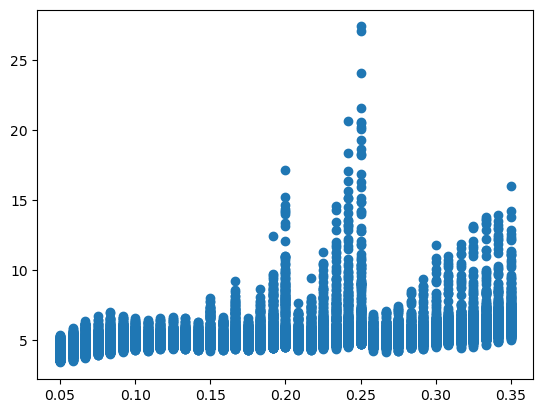

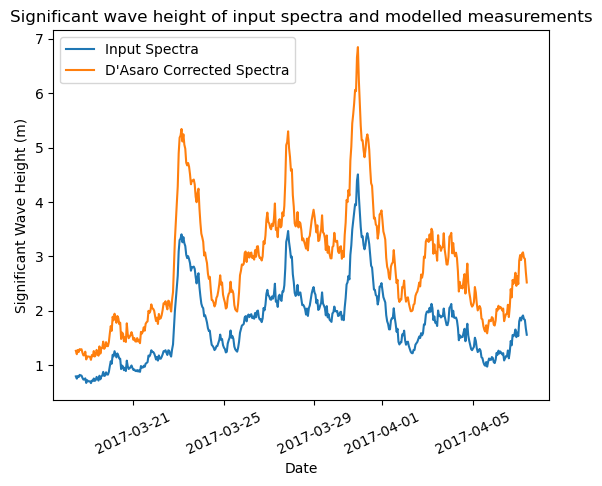

In [3]:
## Calculate the Gain from Eric2 to Surface spectra

#%load_ext autoreload
#%autoreload 2

import datetime
from sklearn.metrics import r2_score


lbound = np.where(fwindow[1:]>=f[0])[0][0]
ubound = np.where(f<=fwindow[-1])[0][-1]

swh_base = sig_wave_height(f[:ubound], input_arr[:ubound, :])
swh_eric = sig_wave_height(fwindow[lbound:], Exx_Eric4_arr[lbound-1:,:])

#input_Hs = np.append(input_Hs, swh_base)
#measured_Hs = np.append(measured_Hs, swh_eric)

Gains = Exx_Eric2_arr/Exx_surf_arr

    
## Subsample the gains (30%) to generate a fit

num_spectra = Gains.shape[1]
num_to_sample = int(num_spectra*0.3)
rand_cols = np.random.randint(0, high=Gains.shape[1], size = num_to_sample)


#For fitting, ignore below 0.05Hz and above 0.4Hz (Noise issues at low freq, windowing noise at high)
hf_stop = 47
lf_stop = 6

Gains_short = Gains[lf_stop:hf_stop, :]
Gains_short_sub = Gains[lf_stop:hf_stop, rand_cols]

#Make an exponential fit to the full data
test = np.reshape(Gains_short, (Gains_short.size,))
x_test = np.repeat(fwindow[lf_stop:hf_stop], Gains_short.shape[1])
plt.scatter(x_test, test)
# fit = np.polyfit(x_test, test, 2)
# p = np.poly1d(fit)
# xp = np.linspace(0.05, 0.4, 100)

# #Make the reduced data exponential fit
# test_sub = np.reshape(Gains_short_sub, (Gains_short_sub.size,))
# x_test_sub = np.repeat(fwindow[lf_stop:hf_stop], Gains_short_sub.shape[1])
# #plt.scatter(x_test_sub, test_sub)
# fit_sub = np.polyfit(x_test_sub, test_sub, 2)
# p_sub = np.poly1d(fit_sub)
# xp_sub = np.linspace(0.05, 0.4, 100)

# #Get r^2 value
# r2 = r2_score(test_sub, p_sub(x_test_sub))


# #Plot the  fits
# plt.figure()
# plt.plot(xp, p(xp), 'r', label="Fit to full data")
# plt.plot(xp_sub, p_sub(xp_sub), '*g', label='Fit to 30% of data')
# plt.xlabel("Frequency (Hz)")
# plt.ylabel("Gain (ZC/Surface Spectra)")
# plt.title("Exponential fits to correction from ZC to surface spectrum data")
# plt.legend()
# output_filepath="/Users/jamesstadler/Documents/UW/TFO/Figures/LCDRI/WaveSimulations/"
# #plt.savefig(output_filepath+"exponential_correction_fits.png")


# #Plot the actual spread of data+ reduced spread
# plt.figure()
# plt.scatter(x_test, test)
# plt.scatter(x_test_sub, test_sub)
# plt.plot(xp, p(xp), 'r', label="Fit to full data")
# plt.plot(xp_sub, p_sub(xp_sub), '*g', label='Fit to 30% of data, r^2='+str(round(r2, 3)))
# plt.xlabel("Frequency (Hz)")
# plt.ylabel("Gain")
# plt.title("ZC Corrected Spectra/Surface Spectra vs. Frequency")
# plt.legend()
# #plt.savefig(output_filepath+"Gains_full_subsampled.png")

# #Plot histograms
# plt.figure()
# plt.hist(test, bins=100, density=True, label="Full Data")
# plt.hist(test_sub, bins=100, density = True, label="Subset Data")
# plt.title("Normalized Histogram of Gain Values")
# plt.xlabel("Gain")
# #plt.savefig(output_filepath+"Gain_Histogram.png")

##
#fixed = Exx_Eric2_arr/np.transpose(np.tile(p_sub(fwindow[1:]), (Exx_Eric2_arr.shape[1], 1)))
#swh_fixed = sig_wave_height(fwindow[lbound:], fixed[lbound-1:, :])

plt.figure()
ts = [datetime.datetime.fromtimestamp(t) for t in times[::2]]
plt.plot(ts, swh_base, label = "Input Spectra")
plt.plot(ts, swh_eric, label="D'Asaro Corrected Spectra")
#plt.plot(ts, swh_fixed, label="Exponential Corrected Spectra")
plt.legend(loc='upper left')
plt.xlabel("Date")
plt.xticks( rotation=25 )
plt.ylabel("Significant Wave Height (m)")
plt.title("Significant wave height of input spectra and modelled measurements")
#plt.savefig(output_filepath+"SigWaveHeight_timeseries_noexp.png", bbox_inches='tight')



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/Users/jamesstadler/Documents/UW/TFO/Code/EM-APEX_1Hz/WaveSimulations/wavesim1d.py:294: RuntimeWarning: overflow encountered in exp
  depth_fact = np.exp(2*k_mat*z_mat)
/Users/jamesstadler/Documents/UW/TFO/Code/EM-APEX_1Hz/WaveSimulations/wavesim1d.py:295: RuntimeWarning: overflow encountered in exp
  depth_fact[np.exp(k_mat*z_mat)>Cmax] = np.nan
/Users/jamesstadler/Documents/UW/TFO/Code/EM-APEX_1Hz/WaveSimulations/wavesim1d.py:304: RuntimeWarning: invalid value encountered in true_divide
  G = np.square((np.square(np.pi)/(np.square(kWT/2)+np.square(np.pi)))*(np.sinh(kWT/2)/(kWT)))
/Users/jamesstadler/Documents/UW/TFO/Code/EM-APEX_1Hz/WaveSimulations/wavesim1d.py:305: RuntimeWarning: invalid value encountered in true_divide
  G_mod = np.square((1/(2*np.pi))*np.sinh(kWT/2)/(np.power(kWT/(2*np.pi), 3)+kWT/(2*np.pi)))
/Users/jamesstadler/Documents/UW/TFO/Code/EM-APEX_1Hz/WaveSimulations/wavesim1d.py:329: RuntimeWarning: overflow encountered in cosh
  G3 = 1/(1+2*h*(np.cosh((z_mat*np.squar

[]

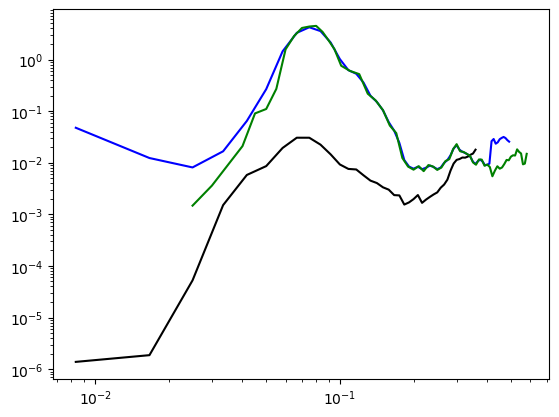

In [7]:
%load_ext autoreload
%autoreload 2

[UUwindow_Eric1, UUwindow_Eric2, UUwindow_Eric3, UUwindow_Eric4mod] = depth_correct_Eric(UUwindow_noise, fwindow, z_new, w, Cmax, fs)

UU_Eric4mod = np.nanmean(np.nanmean(UUwindow_Eric4mod, axis=0), axis=0)/(int(w/2)*fs)
Exx_Eric4mod = UU_Eric4mod[1:]/ (np.square((2*np.pi*fwindow[1:])))

plt.loglog(fwindow[1:], Exx_surf, 'b')
plt.loglog(fwindow[1:], Exx_Eric4, 'k')
#plt.loglog(fwindow[1:], Exx_Eric4mod, color='C4')
plt.loglog(f, test_spectra , 'g')
#plt.loglog(fwindow[1:], fixed[:, -1], '--k')
plt.loglog()


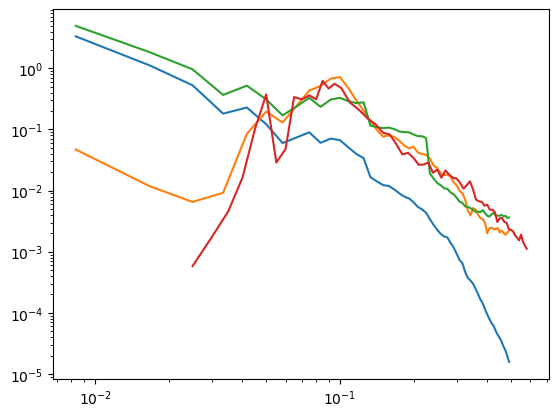

In [29]:
plt.loglog(fwindow[1:], Exx_Eric4_arr[:, 5])
plt.loglog(fwindow[1:], Exx_surf_arr[:, 5])
plt.loglog(fwindow[1:], fixed[:, 5])
plt.loglog(f, input_arr[:, 1])


In [8]:
f

array([0.025  , 0.03   , 0.035  , 0.04   , 0.045  , 0.05   , 0.055  ,
       0.06   , 0.065  , 0.07   , 0.075  , 0.08   , 0.085  , 0.09   ,
       0.095  , 0.10125, 0.11   , 0.12   , 0.13   , 0.14   , 0.15   ,
       0.16   , 0.17   , 0.18   , 0.19   , 0.2    , 0.21   , 0.22   ,
       0.23   , 0.24   , 0.25   , 0.26   , 0.27   , 0.28   , 0.29   ,
       0.3    , 0.31   , 0.32   , 0.33   , 0.34   , 0.35   , 0.36   ,
       0.37   , 0.38   , 0.39   , 0.4    , 0.41   , 0.42   , 0.43   ,
       0.44   , 0.45   , 0.46   , 0.47   , 0.48   , 0.49   , 0.5    ,
       0.51   , 0.52   , 0.53   , 0.54   , 0.55   , 0.56   , 0.57   ,
       0.58   ], dtype=float32)

In [27]:
fit_sub

array([79.28227315, -9.72860516,  1.73395707])

In [12]:
np.polyfit(x_test_sub, test_sub, 2, full=True)

(array([78.50899182, -9.46848757,  1.75178033]),
 array([4081.29992082]),
 3,
 array([1.66824607, 0.46116713, 0.0654212 ]),
 1.3018475186754586e-12)

In [13]:
np.sum(np.square(test_sub-np.mean(test_sub)))

41169.73238122619

In [15]:
1-(4081.29992082/41169.73238122619)

0.9008664937865587

In [16]:

from sklearn.metrics import r2_score

r2_score(test_sub, p_sub(x_test_sub))

0.9008664937864586

In [11]:
len(p_sub(xp_sub))

100